In [12]:
import torch, torchvision
print(torch.__version__,torch.cuda.is_available())

import mmdet
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
import mmocr
import matplotlib.pyplot as plt
import cv2

from imutils.object_detection import non_max_suppression
from skewness import *

from mmocr.apis import MMOCRInferencer

import cv2
from craft_text_detector import Craft
import matplotlib.pyplot as plt
import os
import pytesseract

import math

2.0.1 True


In [13]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [14]:
ocr = MMOCRInferencer(det='TextSnake')

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textdet/textsnake/textsnake_resnet50-oclip_fpn-unet_1200e_ctw1500/textsnake_resnet50-oclip_fpn-unet_1200e_ctw1500_20221101_134814-a216e5b2.pth


In [15]:
img = cv2.imread('images/odd_5.jpg')
image = img.copy()
det = ocr(img)
imgc = img.copy()
boxes = det['predictions'][0]['det_polygons']

Inference ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   

In [16]:
boxes

[[384.5950704225352,
  141.11548913043478,
  384.09624413145536,
  141.61413043478262,
  380.1056338028169,
  141.61413043478262,
  379.6068075117371,
  142.11277173913044,
  375.61619718309856,
  142.11277173913044,
  375.11737089201876,
  142.61141304347828,
  373.62089201877933,
  142.61141304347828,
  373.1220657276995,
  143.1100543478261,
  370.12910798122067,
  143.1100543478261,
  369.6302816901408,
  143.6086956521739,
  368.1338028169014,
  143.6086956521739,
  367.63497652582157,
  144.10733695652175,
  366.63732394366195,
  144.10733695652175,
  366.13849765258215,
  144.60597826086956,
  362.1478873239437,
  144.60597826086956,
  361.6490610328638,
  145.1046195652174,
  360.1525821596244,
  145.1046195652174,
  359.6537558685446,
  145.60326086956522,
  358.65610328638496,
  145.60326086956522,
  358.15727699530515,
  146.10190217391306,
  356.1619718309859,
  146.10190217391306,
  355.6631455399061,
  146.60054347826087,
  354.16666666666663,
  146.60054347826087,
  353.

In [17]:
def order_contour_clockwise(contour):
    # Calculate the centroid of the contour
    M = cv2.moments(contour)
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    
    # Calculate the angle of each point with respect to the centroid
    def angle_key(point):
        x, y = point
        # print(np.degrees(np.arctan2(y - cy, x - cx)))
        return np.arctan2(y - cy, x - cx)

    
    # Sort the contour points based on the angle with respect to centroid
    sorted_contour = sorted(contour, key=angle_key, reverse = False)  # Clockwise
    
    return np.array(sorted_contour)

In [18]:
def order_contour_anti_clockwise(contour):
    # Calculate the centroid of the contour
    M = cv2.moments(contour)
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    
    # Calculate the angle of each point with respect to the centroid
    def angle_key(point):
        x, y = point
        # print(np.degrees(np.arctan2(y - cy, x - cx)))
        return np.arctan2(y - cy, x - cx)

    
    # Sort the contour points based on the angle with respect to centroid
    sorted_contour = sorted(contour, key=angle_key)  # Clockwise
    
    return np.array(sorted_contour)

In [19]:
# def orientation(contour):
#     # Extract the first and last points of the contour
#     first_point = contour[0]
#     last_point = contour[1]

#     # Calculate the cross product between the vector and the positive x-axis
#     cross_product = -np.cross(last_point, first_point)
#     print(f'Cross Product : {cross_product}')
#     if cross_product > 0:
#         # The contour makes a counterclockwise angle with the x-axis.
#         return 0
#     elif cross_product < 0:
#         # The contour makes a clockwise angle with the x-axis.
#         return 1
#     else:
#         # The contour is aligned with the x-axis.
#         return None

In [20]:
def orientation(contour):
    new_contour = order_contour_clockwise(contour)
    # print(new_contour)
    if np.array_equal(new_contour, contour):
        return 0
    else:
        return 1

Inference ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   

[[ 58  83]
 [141  60]
 [148  85]
 [ 64 108]]
clockwise
[[ 58  83]
 [141  60]
 [148  85]
 [ 64 108]]
before 74.68717956542969
here
angle: 76.5042667192042


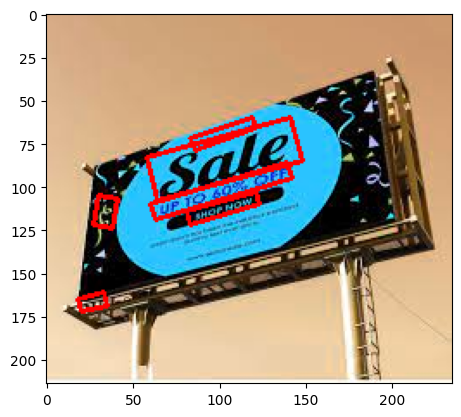

In [21]:
img = cv2.imread('images/testss.jpg')
image = img.copy()
det = ocr(img)
imgc = img.copy()
boxes = det['predictions'][0]['det_polygons']

angled_boxes = []
for box in boxes:
    if len(box) >= 3:
        # Convert box points to numpy array for easier manipulation
        box_points = np.array(box, dtype=np.int32).reshape(-1, 2)

        # Calculate the centroid of the polygon
        centroid = np.mean(box_points, axis=0)

        # Calculate angles from the centroid to the vertices
        angles = [math.atan2(p[1] - centroid[1], p[0] - centroid[0]) for p in box_points]

        # Calculate average angle
        avg_angle = sum(angles) / len(angles)

        # Determine the threshold based on your specific case
        threshold = math.pi / 4  # 45 degrees

        # Compare the average angle with the threshold to determine orientation
        is_clockwise = avg_angle > threshold

        # If clockwise, reverse the points
        if is_clockwise:
            box_points = box_points[::-1]

        # Calculate the minimum bounding rectangle
        rotated_rect = cv2.minAreaRect(box_points)
        box_vertices = cv2.boxPoints(rotated_rect)
        box_vertices = np.int0(box_vertices)
        angled_boxes.append(box_vertices)

        # Draw the rotated rectangle
        cv2.drawContours(img, [box_vertices], 0, (255, 0, 0), 2)

plt.imshow(img)

largest_contour = max(angled_boxes, key=cv2.contourArea)
print(largest_contour)
counter_clockwise = orientation(largest_contour)

if counter_clockwise:
    # Calculate the angle for counterclockwise orientation
    largest_contour = order_contour_anti_clockwise(largest_contour)
    print(largest_contour)
    print('counter_clockwise')
    orientation(largest_contour)

    _,_,angle = cv2.minAreaRect(largest_contour)
    print(f'ag : {angle}')
    # if angle < -45:
    #     print('here')
    #     x1, y1 = largest_contour[1]
    #     x2, y2 = largest_contour[0]
    #     if x2 - x1 != 0:
    #         slope = (y2 - y1) / (x2 - x1)
    #         angle_radians = np.arctan(slope)
    #         angle = np.degrees(angle_radians)
    #     else:
    #         angle = 90
    if angle > 45:
        # angle = angle -  90

        x1, y1 = largest_contour[3]
        x2, y2 = largest_contour[0]
        if x2 - x1 != 0:
            slope = (y2 - y1) / (x2 - x1)
            angle_radians = np.arctan(slope)
            angle = np.degrees(angle_radians)
        else:
            angle = 90
else:
    print('clockwise')
    # Calculate the angle for clockwise orientation
    largest_contour = order_contour_clockwise(largest_contour)
    print(largest_contour)
    _,_,angle = cv2.minAreaRect(largest_contour)
    print(f'before {angle}')
    if angle > 45:
        print('here')
        # angle = angle -  90

        x1, y1 = largest_contour[3]
        x2, y2 = largest_contour[0]
        if x2 - x1 != 0:
            slope = (y2 - y1) / (x2 - x1)
            angle_radians = np.arctan(slope)
            angle = np.degrees(angle_radians)
        else:
            angle = 90
    if angle < 45:
        # angle = angle -  90

        x1, y1 = largest_contour[3]
        x2, y2 = largest_contour[0]
        if x2 - x1 != 0:
            slope = (y2 - y1) / (x2 - x1)
            angle_radians = np.arctan(slope)
            angle = np.degrees(angle_radians)
        else:
            angle = 90
    # x1, y1 = largest_contour[3]
    # x2, y2 = largest_contour[0]
    # if x2 - x1 != 0:
    #     slope = (y2 - y1) / (x2 - x1)
    #     angle_radians = np.arctan(slope)
    #     angle = np.degrees(angle_radians)
    # else:
    #     angle = 90

print(f'angle: {angle}')
# print(f'angle_degrees : {angle_degrees}')

height, width = img.shape[:2]
center = (width // 2, height // 2)
imgc = cv2.drawContours(imgc,[largest_contour],0,(0,255,0),2)
if angle != 90:
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale=1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
else:
    rotated_image = image.copy()

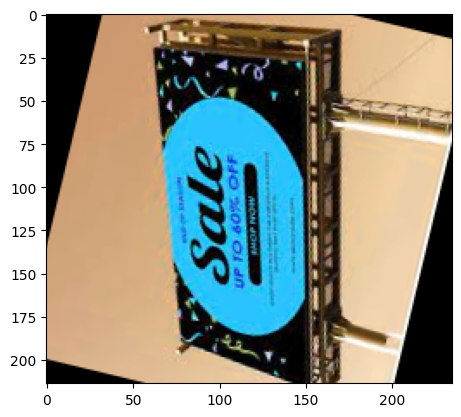

In [22]:
plt.imshow(rotated_image)
plt.show()

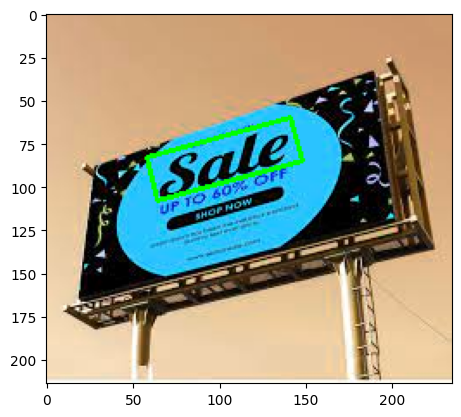

In [23]:
plt.imshow(imgc)

In [24]:
largest_contour

array([[ 58,  83],
       [141,  60],
       [148,  85],
       [ 64, 108]], dtype=int64)

In [25]:
angle = 98 % 180  
angle

98

In [26]:
angle

98